In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import os.path
import requests

# Data analysis of Covis-19 cumulated cases by countries

Les données de l'incidence du Covid-19 sont disponibles du site Web du [ Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE)](https://systems.jhu.edu/). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une région ou pays. Nous téléchargeons le jeu de données complet si il n'est pas en local sur le dépot git. Le jeu de données commence le 22 Janvier avec les données quotidiennes des cas cumulés par région.  

In [2]:
data_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
local_file_name = './local_data_covid.csv'
if not os.path.isfile(local_file_name):
    print('file does not exist, downloading...')
    resource = requests.get(data_url, allow_redirects=True)
    print(resource)
    output = open(local_file_name,"wb")
    output.write(resource.content)
    output.close()
    print('local file saved with name : ', local_file_name)

In [3]:
raw_data = pd.read_csv(local_file_name, skiprows=0)
raw_data.head()

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20   ...     8/1/21  8/2/21  8/3/21  \
0        0        0        0        0   ...     146523  147985  148572   
1        0        0        0        0   ...     133121  133146  133211   
2        0        0        0        0   ...     172564  173922  175229   
3        0        0        0        0   ...      14678   14747   14766   
4        0        0        0        0   ...      42815   42970   43070   

   8/4/21  8/5/21  8/6/21  8/7/21  8/8/21  8/9/21  8/10/21  
0  148933  149361  149810  149810  149810  150778   151013  
1  133310  133442  133591  133730  133912  133981   134201  
2  176724  178013  179216  180356  181376  182368   183347  
3   14797   14809   14836   14836   14836   14836    14873  
4   43158   43269   43487   43592   43662   43747    43890  

[5 rows x 571 columns]

In [4]:
raw_data[raw_data.isnull().any(axis=1)].head()

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20   ...     8/1/21  8/2/21  8/3/21  \
0        0        0        0        0   ...     146523  147985  148572   
1        0        0        0        0   ...     133121  133146  133211   
2        0        0        0        0   ...     172564  173922  175229   
3        0        0        0        0   ...      14678   14747   14766   
4        0        0        0        0   ...      42815   42970   43070   

   8/4/21  8/5/21  8/6/21  8/7/21  8/8/21  8/9/21  8/10/21  
0  148933  149361  149810  149810  149810  150778   151013  
1  133310  133442  133591  133730  133912  133981   134201  
2  176724  178013  179216  180356  181376  182368   183347  
3   14797   14809   14836   14836   14836   14836    14873  
4   43158   43269   43487   43592   43662   43747    43890  

[5 rows x 571 columns]

On vérifie qu'il ne manque pas de données. Les valeurs NaN proviennent des pays qui ne possèdent pas de province/state. On peut également vérifier l'entrée correspondant à la province de Hong Kong. On veut pouvoir le séparer du reste des provinces de la Chine. Mon choix a été de changer le Country/Region de cette ligne en Hong Kong. 

In [5]:
raw_data[raw_data["Province/State"]=="Hong Kong"]

Province/State Country/Region   Lat   Long  1/22/20  1/23/20  1/24/20  \
70      Hong Kong          China  22.3  114.2        0        2        2   

    1/25/20  1/26/20  1/27/20   ...     8/1/21  8/2/21  8/3/21  8/4/21  \
70        5        8        8   ...      11987   11990   11994   11996   

    8/5/21  8/6/21  8/7/21  8/8/21  8/9/21  8/10/21  
70   12002   12004   12011   12013   12015    12019  

[1 rows x 571 columns]

In [6]:
data = raw_data.copy()

In [7]:
data.loc[data["Province/State"] == "Hong Kong", "Country/Region"] = "Hong Kong"

In [8]:
data[data["Province/State"] == "Hong Kong"]

Province/State Country/Region   Lat   Long  1/22/20  1/23/20  1/24/20  \
70      Hong Kong      Hong Kong  22.3  114.2        0        2        2   

    1/25/20  1/26/20  1/27/20   ...     8/1/21  8/2/21  8/3/21  8/4/21  \
70        5        8        8   ...      11987   11990   11994   11996   

    8/5/21  8/6/21  8/7/21  8/8/21  8/9/21  8/10/21  
70   12002   12004   12011   12013   12015    12019  

[1 rows x 571 columns]

Le cas de Hong Kong est traité on peut maintenant trier les données pour selectionner celles des pays qui nous intéressent et sommer pour avoir les données par pays. On supprime également les champs dont on a plus besoin : Lat, Long et Province. 

In [9]:
data = data.drop("Lat", axis=1)
data = data.drop("Long", axis=1)

In [10]:
country_list = ["Belgium", "China", "Hong Kong", "France", "Germany",
                "Iran", "Italy", "Japan", "Korea, South", "Netherlands",
                "Portugal", "Spain", "United Kingdom", "US"]

data = data[data["Country/Region"].isin(country_list)]
dataToPlot = data.drop("Province/State", axis=1)

In [11]:
dataToPlot = dataToPlot.groupby(['Country/Region']).sum()

Enfin on converti les indexes en date pandas et on peut plotter (en echelle linéaire puis en échelle log) :

In [12]:
def converttodate(date):
    pdate = pd.to_datetime(date, format='%m/%d/%y')
    return pdate
dataToPlot.columns = [converttodate(date) for date in dataToPlot.columns]

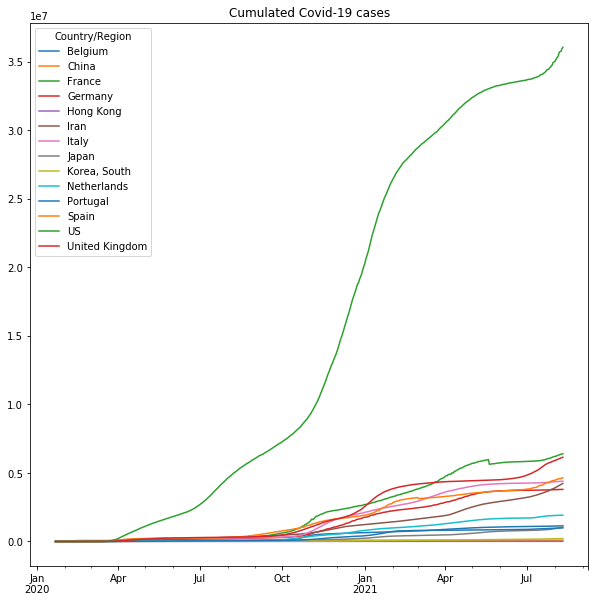

In [13]:
dataToPlot.T.plot(figsize=(10,10), title="Cumulated Covid-19 cases")

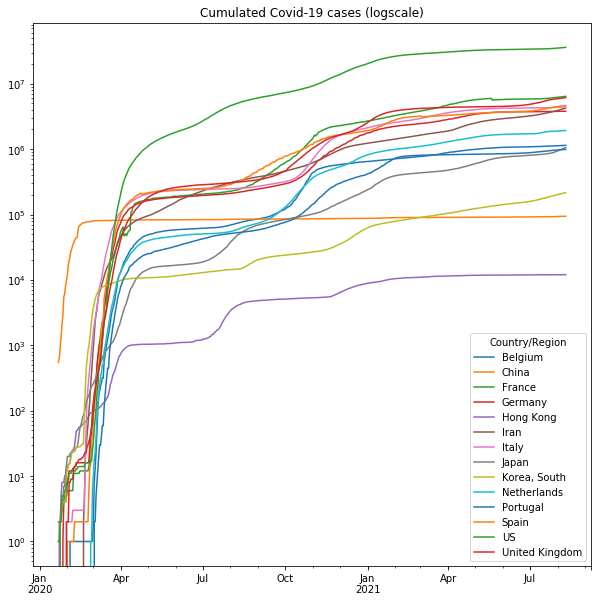

In [14]:
dataToPlot.T.plot(figsize=(10,10), logy = True, title="Cumulated Covid-19 cases (logscale)")
